## Fourier, Wavelet and Feature Extraction

In this lab we will apply our knowledge in the lectures on transform domain methods and feature extraction. 

### 1. Frequency Domain Processing 

Periodic noise is a significant problem for classical analog image transmission. Many of the archived footage has significant periodic noise problem due to the interference from powerline or other radio sources. The figure below is an example. 

![alt text](https://drive.google.com/uc?export=view&id=11Lr4PS6RMD6hSd3U2cjImsZK8_QpX2J4)

In this problem, we are to explore both bandreject and notch filters in removing periodic noise. Any types of bandreject and notch filter implementations including ideal, Gaussian, and Butterworth can be used here but they need to be implemented in frequency domain. Test the results using the two noisy images in this [archive](https://drive.google.com/open?id=1vToYT-rTMjTlJuFVQ9UJtxO1R4r0XN3F). 

**Method**

Before applying any filters, we need to pad the image. Otherwise, the image will appear darker when we apply the IFFT. As mentioned in class, the image's size must be doubled by two. Therefore, the image of size MxN becomes PxQ, where P = 2M and Q = 2M. We then multiply each pixel by $(-1)^{x+y}$ so that when we take the FFT, the response is shifted to the center of the image. We then apply the FFT on the image, using `fft2`.

***Determining the periodic frequency***
To determine the frequency that causes the periodic noise, we took the magnitude of the image and created a high pass filter that emphasized the locations where the periodic frequencies occur. We then used the equation in class to create a notch butterworth filter. This was implemented in frequency domain, then multiplied against the image. We then take the 2D-IFFT to get to time domain and multiply the resulting image by $(-1)^{x+y}$ to get the filtered output.

However, at this stage, the image is still padded, so we crop the output to the original size.

***Variables***

Through trial and error, we determined that the best $(u_{k},v_{k})$ was $(101,102)$. We also used an $n=5$ order filter, since when we tested with lower orders, the amount of time taken to run the program was still the same. We also used D0 = 95, and the results are much better compared to the other filters. However, we noticed that there is a tradeoff between the quality of the filtering versus the amount of time taken to run.

We commented out all the filters we tested, but on average, the gaussian filter was the fastest for both band reject and notch filters. However, it still had rippling, even when we tried fine-tuning the gaussian filter. The results of the band-reject filters are worse compared to the notch filters, which is expected, since the notch is highly selective in what frequencies it diminishes.

We also timed the results in seconds, which is shown in the output.

Time Butterworth Notch = 6.302587985992432
For image 0
Time Butterworth Notch = 6.438664197921753
For image 1


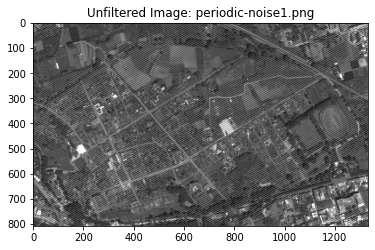

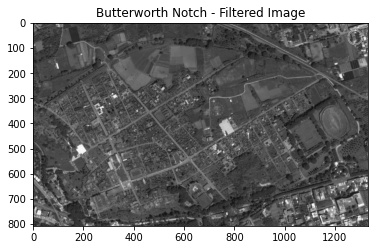

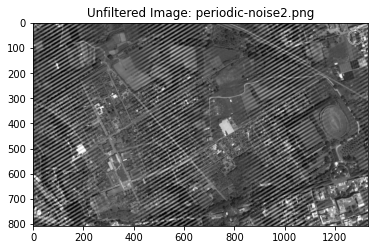

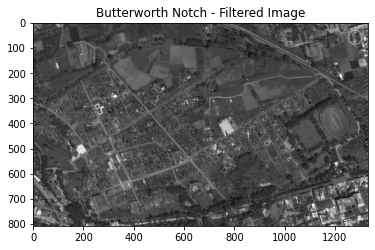

In [ ]:
from PIL import Image
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
import numpy.fft as fft
import cv2
import time


def display_image(img,title=''):
  plt.figure()
  plt.title(title)
  plt.gray()
  plt.imshow(img)


def print_matrix(G):
  U,V = G.shape
  for u in range(U):
    for v in range(V):
      print(f"{G[u][v]}",end = " ")
    print("")

def create_gaussian_HPF(G, D0, C):
  U,V = G.shape
  D = np.zeros([U,V])
  eps = np.finfo(float).eps

  for u in range(U):
    for v in range(V):
      D[u][v] = math.sqrt((u - U/2)**2 + (v - V/2)**2)

  frac = np.divide(np.power(D,2),D0**2)
  gauss_HPF = C*(1 - np.exp(-0.5*frac))
  
  return gauss_HPF


def create_gaussian_br_filter(G,D0,W):
  U,V = G.shape
  D = np.zeros([U,V])
  eps = np.finfo(float).eps

  for u in range(U):
    for v in range(V):
      D[u][v] = math.sqrt((u - U/2)**2 + (v - V/2)**2)

  frac = np.divide((np.power(D,2) - D0**2),(D+eps)*(W+eps))
  H_gauss_br = 1 - np.exp(-0.5*np.power(frac,2))
  return H_gauss_br


def create_butter_br_filter(G,D0,n,W):
  U,V = G.shape
  D = np.zeros([U,V])
  eps = np.finfo(float).eps

  for u in range(U):
    for v in range(V):
      D[u][v] = math.sqrt((u - U/2)**2 + (v - V/2)**2)

  frac = np.divide(D*W,(np.power(D,2) - (D0)**2) +eps)
  H_butter_br = 1/(1 + np.power(frac,2*n))
  return H_butter_br


def create_ideal_br_filter(G,D0,W):
  U,V = G.shape
  D = np.zeros([U,V])
  H = np.zeros([U,V])
  eps = np.finfo(float).eps


  # get D1
  for u in range(U):
    for v in range(V):
      D[u][v] = math.sqrt((u - U/2)**2 + (v - V/2)**2)

  
  for u in range(U):
    for v in range(V):
      if(D[u][v] < (D0 - 0.5*W) or D[u][v] > (D0 + 0.5*W)):
        H[u][v] = 1
  
  return H



def create_butter_notch_filter(G,D0,n,uk,vk):
  U,V = G.shape
  D1 = np.zeros([U,V])
  D2 = np.zeros([U,V])
  eps = np.finfo(float).eps


  # get D1
  for u in range(U):
    for v in range(V):
      D1[u][v] = math.sqrt((u - U/2 - uk)**2 + (v - V/2 -vk)**2)

  # get D2
  for u in range(U):
    for v in range(V):
      D2[u][v] = math.sqrt((u - U/2 + uk)**2 + (v - V/2 + vk)**2)

  frac = np.divide(D0**2,np.multiply(D1,D2))
  H_butter_notch = 1/(1 + np.power(frac,n))
  return H_butter_notch



def create_gaussian_notch_filter(G,D0,uk,vk):
  U,V = G.shape
  D1 = np.zeros([U,V])
  D2 = np.zeros([U,V])
  eps = np.finfo(float).eps


  # get D1
  for u in range(U):
    for v in range(V):
      D1[u][v] = math.sqrt((u - U/2 - uk)**2 + (v - V/2 - vk)**2)

  # get D2
  for u in range(U):
    for v in range(V):
      D2[u][v] = math.sqrt((u - U/2 + uk)**2 + (v - V/2 + vk)**2)


  frac = np.divide(np.multiply(D1,D2),D0**2)
  H_gauss_notch = 1 - np.exp(-0.5*frac)

  return H_gauss_notch


def create_ideal_notch_filter(G,D0,uk,vk):
  U,V = G.shape
  D1 = np.zeros([U,V])
  D2 = np.zeros([U,V])
  H = np.ones([U,V])
  eps = np.finfo(float).eps


  # get D1
  for u in range(U):
    for v in range(V):
      D1[u][v] = math.sqrt((u - U/2 - uk)**2 + (v - V/2 - vk)**2)

  # get D2
  for u in range(U):
    for v in range(V):
      D2[u][v] = math.sqrt((u - U/2 + uk)**2 + (v - V/2 + vk)**2)

  for u in range(U):
    for v in range(V):
      if(D1[u][v] <= D0 or D2[u][v] <= D0):
        H[u][v] = 0
  
  return H

def getFilteredImage1(F):
  U,V = F.shape
  
  # start = time.time()
  # H_gauss_br = create_gaussian_br_filter(F,D0=290,W=50)
  # F1 = np.multiply(F, H_gauss_br)
  # f1 = fft.ifft2(F1)
  # end = time.time()
  # print(f"Time Gaussian BR = {end-start}")

  # start = time.time()
  # H_gauss_notch = create_gaussian_notch_filter(F,D0=130,uk=U/(13-5),vk=V/13)
  # F2 = np.multiply(F, H_gauss_notch)
  # f2 = fft.ifft2(F2)
  # end = time.time()
  # print(f"Time Gaussian Notch = {end-start}")
  
  # start = time.time()
  # H_butter_br = create_butter_br_filter(F,D0=290,n=5,W=50)
  # F3 = np.multiply(F, H_butter_br)
  # f3 = fft.ifft2(F3)
  # end = time.time()
  # print(f"Time Butter BR = {end-start}")

  start = time.time()
  H_butter_notch = create_butter_notch_filter(F,D0=130,n=5,uk=U/(8),vk=V/13)
  F4 = np.multiply(F, H_butter_notch)
  f4 = fft.ifft2(F4)
  end = time.time()
  print(f"Time Butterworth Notch = {end-start}")
  
  # start = time.time()
  # H_ideal_br = create_ideal_br_filter(F,D0=290,W=30)
  # F5 = np.multiply(F, H_ideal_br)
  # f5 = fft.ifft2(F5)
  # end = time.time()
  # print(f"Time Ideal BR = {end-start}")

  # start = time.time()
  # H_ideal_notch = create_ideal_notch_filter(F, D0=65, uk=U/(13-5), vk=V/13)
  # F6 = np.multiply(F, H_ideal_notch)
  # f6 = fft.ifft2(F6)
  # end = time.time()
  # print(f"Time Ideal Notch = {end-start}")
  # display_image(abs(H_ideal_br), "Ideal BR response")
  # display_image(abs(H_ideal_notch), "Ideal Notch response")
  
  # return f1,f2,f3,f4,f5,f6
  return f4


def getFilteredImage2(F):
  U,V = F.shape
  
  # start = time.time()
  # H_gauss_br = create_gaussian_br_filter(F,D0=140,W=20)
  # F1 = np.multiply(F, H_gauss_br)
  # f1 = fft.ifft2(F1)
  # end = time.time()
  # print(f"Time Gaussian BR = {end-start}")

  # start = time.time()
  # H_gauss_notch = create_gaussian_notch_filter(F, D0=95, uk=U/(26-10), vk=V/26)
  # F2 = np.multiply(F, H_gauss_notch)
  # f2 = fft.ifft2(F2)
  # end = time.time()
  # print(f"Time Gaussian Notch = {end-start}")

  # start = time.time()
  # H_butter_br = create_butter_br_filter(F,D0=140,n=5,W=20)
  # F3 = np.multiply(F, H_butter_br)
  # f3 = fft.ifft2(F3)
  # end = time.time()
  # print(f"Time Butterworth BR = {end-start}")

  start = time.time()
  H_butter_notch = create_butter_notch_filter(F, D0=95, n=5, uk=U/(16), vk=V/26)
  F4 = np.multiply(F, H_butter_notch)
  f4 = fft.ifft2(F4)
  end = time.time()
  print(f"Time Butterworth Notch = {end-start}")

  # start = time.time()
  # H_ideal_br = create_ideal_br_filter(F,D0=140,W=15)
  # F5 = np.multiply(F, H_ideal_br)
  # f5 = fft.ifft2(F5)
  # end = time.time()
  # print(f"Time Ideal BR = {end-start}")

  # start = time.time()
  # H_ideal_notch = create_ideal_notch_filter(F, D0=50, uk=U/(26-10), vk=V/26)
  # F6 = np.multiply(F, H_ideal_notch)
  # f6 = fft.ifft2(F6)
  # end = time.time()
  # print(f"Time Ideal Notch = {end-start}")

  # display_image(abs(H_ideal_br), "Ideal BR response")
  # display_image(abs(H_ideal_notch), "Ideal Notch response")
  
  # return f1,f2,f3,f4,f5,f6
  return f4


def main():
  # periodic1_url = 'https://drive.google.com/uc?id=1Z8qS1uCNq7Wnq503mTqrFvFqPBzfweWL'
  # periodic2_url = 'https://drive.google.com/uc?id=1oGl2LFG7OcjjnX6XZktnCiESf4I2ncS-'

  filenames = ["periodic-noise1.png", "periodic-noise2.png"]

  for filename in enumerate(filenames):
    img = cv2.imread(filename[1])
    img = img[:,:,0]
    img = np.uint8(img)
    M,N = img.shape
    display_image(img, f'Unfiltered Image: {filename[1]}')

    P = 2*M
    Q = 2*N
    padded = np.zeros([P,Q])
    padded[:M,:N] = img

    x = np.arange(P)
    y = np.arange(Q)

    xx,yy = np.meshgrid(y,x)
    z = xx+yy
    z = (-1)**z
    padded = np.multiply(padded,z)
    F = fft.fft2(padded)

    # high pass the noise to see the frequencies better
    # hpf = create_gaussian_HPF(F,10,3)
    # F_hp = np.multiply(F,hpf)
    # display_image(abs(F_hp), "HPF" + filename[1])

    if(filename[0] == 0):
      # f,f2,f3,f4,f5,f6 = getFilteredImage1(F)
      f4 = getFilteredImage1(F)

    if(filename[0] == 1):
      # f,f2,f3,f4,f5,f6 = getFilteredImage2(F)
      f4 = getFilteredImage2(F)

    # f = f[:M,:N]
    # f2 = f2[:M,:N]
    # f3 = f3[:M,:N]
    f4 = f4[:M,:N]
    # f5 = f5[:M,:N]
    # f6 = f6[:M,:N]

    if(filename[0] == 0):
      # plt.imsave('clean1_br.png', abs(f), cmap='gray')
      # plt.imsave('clean1_notch.png', abs(f2), cmap='gray')
      # plt.imsave('clean1_butter_br.png', abs(f3), cmap='gray')
      plt.imsave('clean1_butter_notch.png', abs(f4), cmap='gray')
      # plt.imsave('clean1_ideal_br.png', abs(f5), cmap='gray')
      # plt.imsave('clean1_ideal_notch.png', abs(f6), cmap='gray')
    if(filename[0] == 1):
      # plt.imsave('clean2_gauss_br.png', abs(f), cmap='gray')
      # plt.imsave('clean2_gauss_notch.png', abs(f2), cmap='gray')
      # plt.imsave('clean2_butter_br.png', abs(f3), cmap='gray')
      plt.imsave('clean2_butter_notch.png', abs(f4), cmap='gray')
      # plt.imsave('clean2_ideal_br.png', abs(f5), cmap='gray')
      # plt.imsave('clean2_ideal_notch.png', abs(f6), cmap='gray')

    print(f"For image {filename[0]}")
    # display_image(abs(f), "Gauss BR - Filtered Image")
    # display_image(abs(f2), "Gauss Notch - Filtered Image")
    # display_image(abs(f3), "Butter BR - Filtered Image")
    display_image(abs(f4), "Butterworth Notch - Filtered Image")
    # display_image(abs(f5), "Ideal BR - Filtered Image")
    # display_image(abs(f6), "Ideal Notch - Filtered Image")

# running the main program
main()
plt.show()


### 2. Wavelet Domain Processing 

2-D Discrete Wavelet Transform is useful for removing noise as well. One popular technique is called Wavelet Shrinkage. The approach is relatively straightforward. Let say we apply a 2-level DWT on an image:

![alt text](https://drive.google.com/uc?export=view&id=1RAKBC7CSI8gAhKm07bHT8G37F_lJcVw3)

Making the assumption that the noise resides mostly in the mid to high frequency bands, we keep the LL2 band intact and modify all the other wavelet coefficients based on the following equation:

![alt text](https://drive.google.com/uc?export=view&id=1S0dJASYpWWqv2MTdGxhnk2g1B-Ho5bkN)

The value of delta depends on which subband the coefficients belong to. Specifically, we use the following rule called the Bayes-Shrink:

![alt text](https://drive.google.com/uc?export=view&id=1EP1siuGriOPfKrLOdqhUj_5guXhWlX0o)

Implement this algorithm and try to denoise these [two images](https://drive.google.com/open?id=1BRaHZKnLYTuPuv9HsVDrla2L6PdGuULT) using different wavelets. For all the basic wavelet transform routines, please use [pywavelet](https://pywavelets.readthedocs.io/en/latest/) software library.
 





**Method**

Here Bayes- Shrink rule is implemented to denoise the images, Image_1 and Image_2, the algorithm is based on the rule provided in the problem statement. 
The wavelet coefficients of the image, cA and cD in our code correspond to diagonal and vertical details.
Here we demonstrated the Haar wavelet which are formed by a set of orthonormal basis of square-shaped functions. 

**Results**

The reconstruction results for image 2 using Bayes Shrink is smoother compared to the original image. However, image 1 is overly denoised and some of the signals were largely decreased and became blurry. 

**Reference**

Some useful resources can also be found here!

[1] [Comparison of Various Thresholding Techniques of Image Denoising](https://www.ijert.org/research/comparison-of-various-thresholding-techniques-of-image-denoising-IJERTV2IS90812.pdf)






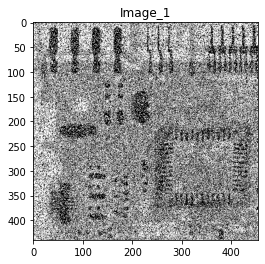

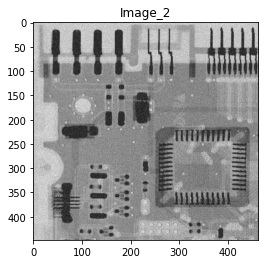

Text(0.5, 1.0, 'Image 2_haar')

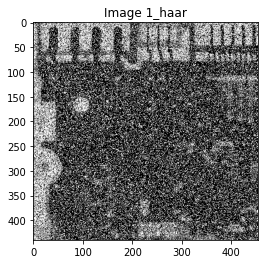

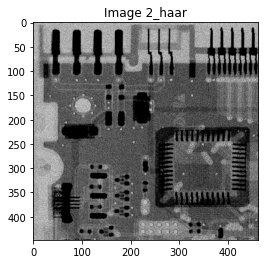

In [ ]:
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import scipy as sp
import pywt
import math

# Url links to the images 
image1_url = 'https://drive.google.com/uc?id=1J79R-yNlJKyNPM003zobe10PUf32nMit'
image2_url = 'https://drive.google.com/uc?id=1varhEPTD9_1aQu_ZKdrwcHAupNKIOpfQ'

img1 = Image.open(urlopen(image1_url))
img2 = Image.open(urlopen(image2_url))

# Displayting the images
def display_image(img,image_file_name = ''):
  plt.figure()
  plt.title(image_file_name)
  plt.imshow(img, cmap='gray')
  plt.grid(False)
  plt.show()

# Displaying the two input images  
display_image(img1,'Image_1')

display_image(img2,'Image_2')

# Change the form of the images to array
img1 = np.array(img1)
img2 = np.array(img2)

# Getting the approximation and details coefficients that are stored in the figure 1 2D array 
WaveletCoeffs = pywt.wavedec2( img1, 'haar', level=2)
WaveletCoeffs = [(abs(i[0]), abs(i[1]), abs(i[2])) for i in WaveletCoeffs]
cA2, cD2, cD1 = WaveletCoeffs
dt=np.dtype('int,float')

# Printing the lengths of the 3 arrays stored in each of the details coefficients cA2, cD2 and cD1
cA2 = np.array(cA2)
l11 = len(cA2[0])
l12 = len(cA2[1])
l13 = len(cA2[2])
l1 = l11+l12+l13
cA2 = np.sum(cA2)

cD2 = np.array(cD2)
l21 = len(cD2[0])
l22 = len(cD2[1])
l23 = len(cD2[2])
l2 = l21+l22+l23
cD2 = np.sum(cD2)

cD1 = np.array(cD1)
l31 = len(cD1[0])
l32 = len(cD1[1])
l33 = len(cD1[2])
l3 = l31 + l32 + l33
cD1  = np.sum(cD1)

# Bayes-Shrink: A soft threshoding method to denoise the images 
sigma_x = (cA2 + cD2)/(0.6745*(l1+l2))
sigma_r = ((cA2)**2 + (cD2)**2 + (cD1)**2)/(l1+l2+l3)
sigma_w = np.sqrt(np.max(sigma_r - sigma_x**2))
delta = (np.square(sigma_x))/sigma_w

y = np.zeros((440,455))  # Creating a 2D array having the same size of image 1

# Modify the wavelet coefficients based on the following equation:
for i in range(np.shape(img1)[0]):
  for j in range(np.shape(img1)[1]):
    if np.abs(img1[i,j]) > delta:
      y[i,j] = np.sign(img1[i,j])*(img1[i,j] - delta)
    else:
      y[i,j] = 0

# Plot the the denoised image_1
plt.figure()
plt.imshow(y, cmap='gray')
plt.title('Image 1_haar')

########################################################
################ Below is for Figure2 ##################
########################################################

# Get the approximation and details coefficients that are stored in the figure 2 2D array 
WaveletCoeffs_2 = pywt.wavedec2( img2, 'haar', level=2)
WaveletCoeffs_2 = [(abs(j[0]), abs(j[1]), abs(j[2])) for j in WaveletCoeffs_2]
cA2_2, cD2_2, cD1_2 = WaveletCoeffs_2
dt=np.dtype('int,float')

# Print the lengths of the 3 arrays stored in the details coefficients cA2.
cA2_2 = np.array(cA2_2)
l11_2 = len(cA2_2[0])
l12_2 = len(cA2_2[1])
l13_2 = len(cA2_2[2])
l1_2 = l11_2 + l12_2 + l13_2
cA2_2 = np.sum(cA2_2)

# Print the lengths of the 3 arrays stored in the details coefficients cD2.
cD2_2 = np.array(cD2_2)
l21_2 = len(cD2_2[0])
l22_2 = len(cD2_2[1])
l23_2 = len(cD2_2[2])
l2_2 = l21_2+l22_2+l23_2
cD2_2 = np.sum(cD2_2)

# Print the lengths of the 3 arrays stored in the details coefficients cD1.
cD1_2 = np.array(cD1_2)
l31_2 = len(cD1_2[0])
l32_2 = len(cD1_2[1])
l33_2 = len(cD1_2[2])
l3_2 = l31_2 + l32_2 + l33_2
cD1_2  = np.sum(cD1_2)

# Bayes-Shrink: A soft threshoding method to denoise the images 
sigma_x_2 = (cD2_2 + cA2_2)/(0.6745*(l1_2 + l2_2))
sigma_r_2 = ((cA2_2)**2 + (cD2_2)**2 + (cD1_2)**2)/((l1_2+l2_2 +l3_2))
sigma_w_2 = np.sqrt(np.max(sigma_r_2 - sigma_x_2**2))
delta_2 = np.square(sigma_x_2)/sigma_w_2

z = np.zeros((448,464))  # Create a 2D array having the same size of the image 2

# Modify the wavelet coefficients based on the following equation:
for m in range(np.shape(img2)[0]):
  for n in range(np.shape(img2)[1]):
    if np.abs(img2[m,n]) > delta_2:
      z[m,n] = np.sign(img2[m,n])*(img2[m,n] - delta_2)
    else:
      z[m,n] = 0

# Plot the the denoised image_2
plt.figure()
plt.imshow(z, cmap='gray')
plt.title('Image 2_haar')


### 3. Feature Extraction and Description

---



This part of the assignment explores the use of automatic feature detection and descriptors for estimating homography, a topic we explore earlier in a [colab practical](https://colab.research.google.com/drive/1sbxmN35-Wbgyj1mkS7QqSHyX8vkU65Yu). The problem is based on a problem from the computer vision course offered in Princeton. 

The goal of the assignment is to perform an image mosaic out of two overlapping input images. For example, given the two overlapping images 

![alt text](https://drive.google.com/uc?export=view&id=1INB4Q5QKCZZQQhN5DG9BnZSKtZSxekQ1)
![alt text](https://drive.google.com/uc?export=view&id=1J1dSgMzwzRlA_U_8If4rv6Yhsxxu1mnB)

the output mosaiced picture looks like the following:

![alt text](https://drive.google.com/uc?export=view&id=11c9BdR0i6HbS64hlg_uYnv-IBOUfvqq5)

Your image mosaicing algorithm should have the following pipeline:
1.   Feature detection - identifies salient feature points (location, scales, orientation) in the image. Suggestions: harris, SIFT
2.   Feature description - computes a compact descriptor for each feature in step 1. Suggestion: SIFT
3.   Feature correspondence - identifies the matching feature descriptors from the two input images. Suggestion: RANSAC
4.   Homography Estimation - estimate the homography based on the correspondences. See the earlier [colab practical](https://colab.research.google.com/drive/1sbxmN35-Wbgyj1mkS7QqSHyX8vkU65Yu)
5.   Image composition - use the computed homography and the two input images to produce the final mosaic. Compare with the output provided. Suggestion: alpha-blending 





# *Part 3*
**Method**

Note: For this code to run, please upload the seoul1.jpg and seoul2.jpg photos. The URL method failed more often than not, so we decided that manual upload is for the best.

Note2: `seoul1.jpg` is `img1` and `seoul2.jpg` is `img2` in the code. We will refer to these in our explanation as such.


***Image Preparation***

We first prep the images by padding the images on all sides. We double the width of both images so that when we combine them, there won't be any cropping. We do the same with the height, but add half the height to the top and half to the bottom, so that the images are in the center. We we later transform image 2, it will span a larger height because it has been warped. Therefore, we do this so the warped image is not cropped.

***Feature Detection & Description***

For feature detection and feature description, instead of using SIFT, we decided to use ORB, which is available on OpenCV. Based on the documentation, ORB is a modification of the SIFT algorithm and is more efficient computationally. Therefore, we decided to use ORB.

The ORB class contains its own feature description and feature detector functions, so we apply those to padded versions of the two images. We use the ORB functions: `detect()` and `compute()`.

***Matching & Homography***

After computing the descriptors, we find matches between the two images using RANSAC. This can be combined with finding the homography, since `cv2.findHomography()` has a parameter that determines how to perform the matching, in which we pass in RANSAC. This generates a transformation matrix, `H`.

Then, can apply `warpPerspective()` onto `img2` using `H` to generate a warped/transformed image, where if we overlap with image1, should show a mosaiced image. The output of `warpPerspective()` is `out2`. 

***Mosaic***

To get the mosaic, we decided to break up the image into 3 parts. Since `img1` and `out2` would overlap when placed on top of each other, we knew that there was section in `img1`. We used the numpy function `numpy.where()` to find pixels where img1 did not overlap with out2. We likewise did the same for `out2`, where we found pixels that did not overlap with `img1`. We leave these sections alone and only apply alpha blending on the overlap. Alpha blending was used to try and smooth the transition between images. We did not use the cv2 function. Instead, we did $\alpha(img1) + (1-\alpha)out2$.

The output is shown below. As shown, the output is not seamless. The boundaries can still be seen. Thus, what we could have done was try to make the alpha vary over the overlap, but we could not get it to work.

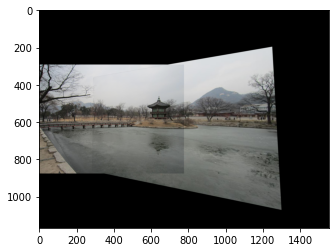

In [ ]:
from PIL import Image
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from urllib.request import urlopen
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import ORB, plot_matches, match_descriptors
import skimage.transform as transform
import skimage.measure as measure

def display_image(img,title=''):
  plt.figure()
  plt.imshow(img)
  plt.title(title)

# take in the images
img1 = cv2.imread('seoul1.jpg')
img2 = cv2.imread('seoul2.jpg')

# convert the color from BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# get the size of the images - both have the same size
h,w,d = img1.shape

# pad the two images so that when transforming them with the homography matrix, we can see the entire warped image
new_img1 = cv2.copyMakeBorder(img1,int(h/2),int(h/2),0,w,cv2.BORDER_CONSTANT)
img1=new_img1

new_img2 = cv2.copyMakeBorder(img2,int(h/2),int(h/2),0,w,cv2.BORDER_CONSTANT)
img2 = new_img2

# get descriptors and key features from first image 
orb = cv2.ORB_create()
kp1 = orb.detect(img1,None)
kp1,des1 = orb.compute(img1,kp1)

# get descriptors and key features from second image
kp2 = orb.detect(img2,None)
kp2,des2 = orb.compute(img2,kp2)

# match the descriptors from both images to find the homography matrix
matcher = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
matches = matcher.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

# get all the points that were matches and reshape them so that we can use them as
# inputs to cv2.findHomography
img1_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
img2_pts = np.float32([ kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# get the homography matrix H used to transform image 2
H, mask = cv2.findHomography(img2_pts,img1_pts,method=cv2.RANSAC,ransacReprojThreshold=6)

# transform img2 with the matrix
out2 = cv2.warpPerspective(img2,H,(2*w,2*h))

# get the image dimensions of the padded image1
# initialize an empty matrix to store the output stitched image
x,y,z = img1.shape
composition = np.zeros([x,y,z],dtype=np.uint8)

# set the alpa value used in alpha blending
a = 0.8

# Break the image into 3 parts.
# 1. Consider all pixels in image1 to be in set A
# 2. Consider all pixels from out2 (transformed image 2) to be in set B.
# 3. A\B = all pixels in A without any pixels from B
# 4. A^B = all pixels in A and pixels in B that are matching
# 5. B\A = all pixels in B without any pixels from A
# For the intersection of pixels, use alpha blending. Then, concatenate A/B and B/A to it.
for i in range(3):
  im1 = img1[:,:,i]
  o2 = out2[:,:,i]
  composition[:,:,i] = np.where((im1 > 0) & (o2 == 0), im1, composition[:,:,i])
  composition[:,:,i] = np.where((im1 > 0) & (o2 > 0), a*im1 + (1-a)*o2, composition[:,:,i])
  composition[:,:,i] = np.where((im1 == 0) & (o2 > 0), o2, composition[:,:,i])


# display result
display_image(composition) 